In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

In [2]:
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

# Loading & Visualization

In [3]:
df = pd.read_csv("data/planet\planet/train_classes.csv") # Adjust as needed
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [4]:
all_tags = set()
for tags in df['tags'].str.split():
    all_tags.update(tags)
all_tags = list(sorted(all_tags))
print(all_tags)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [5]:
tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(len(tag_to_idx))

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
17


## Imbalance Metrics

In [6]:
# Based on https://link.springer.com/chapter/10.1007/978-3-642-40846-5_16 

# Calculate h(y, Yi)
def h(y, Yi):
    return 1 if y in Yi else 0

# Calculate IRperLabel for each label y
def calculate_IRperLabel(all_labels, df):
    IR = {}
    # Split tags into lists of labels
    df['label_list'] = df['tags'].apply(lambda x: x.split())
    for y in all_labels:
        label_counts = [sum(h(y, Yi) for Yi in df['label_list'])]
        majority_label_count = sum(label_counts)
        
        # Get the number of labels in the dataset
        IR[y] = majority_label_count / len(df) if len(df) > 0 else 0

    return IR

# Calculate MeanIR (average imbalance ratio)
def calculate_MeanIR(IR):
    return np.mean(list(IR.values()))

# Calculate CVIR (coefficient of variation of imbalance ratio)
def calculate_CVIR(IR, MeanIR):
    mean_squared_diff = np.mean([(val - MeanIR)**2 for val in IR.values()])
    return np.sqrt(mean_squared_diff) / MeanIR if MeanIR != 0 else 0


In [7]:
def plot_spread(data):
    # Flatten the list of labels
    all_tags = data['tags'].apply(lambda x: x.split() if isinstance(x, str) else x)
    flattened_tags = [tag for sublist in all_tags for tag in sublist]

    # Convert to a DataFrame for easy handling
    tag_df = pd.DataFrame(flattened_tags, columns=['tag'])

    # Sort tags alphabetically
    sorted_tag_counts = tag_df['tag'].value_counts().sort_index()  # Sort alphabetically by tag
    sorted_tag_df = pd.DataFrame({'tag': sorted_tag_counts.index, 'count': sorted_tag_counts.values})

    # Plot the distribution horizontally
    plt.figure(figsize=(12, 6))  # Increase figure size to accommodate labels
    sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data

    # Add labels and title
    plt.title('Tag Distribution in Multi-Tag Dataset', fontsize=16)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Tags', fontsize=14)

    # Adjust label sizes and positioning
    plt.tight_layout()

    # Display the plot
    plt.show()

def get_std_dev(data):
    tag_counts = Counter(tag for tags in data['tags'] for tag in tags)
    frequencies = list(tag_counts.values())
    imbalance_std = np.std(frequencies)
    print(f"Standard Deviation of Tag Frequencies: {imbalance_std}")


C:\Users\xxpur\AppData\Local\Temp\ipykernel_20192\3117131438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


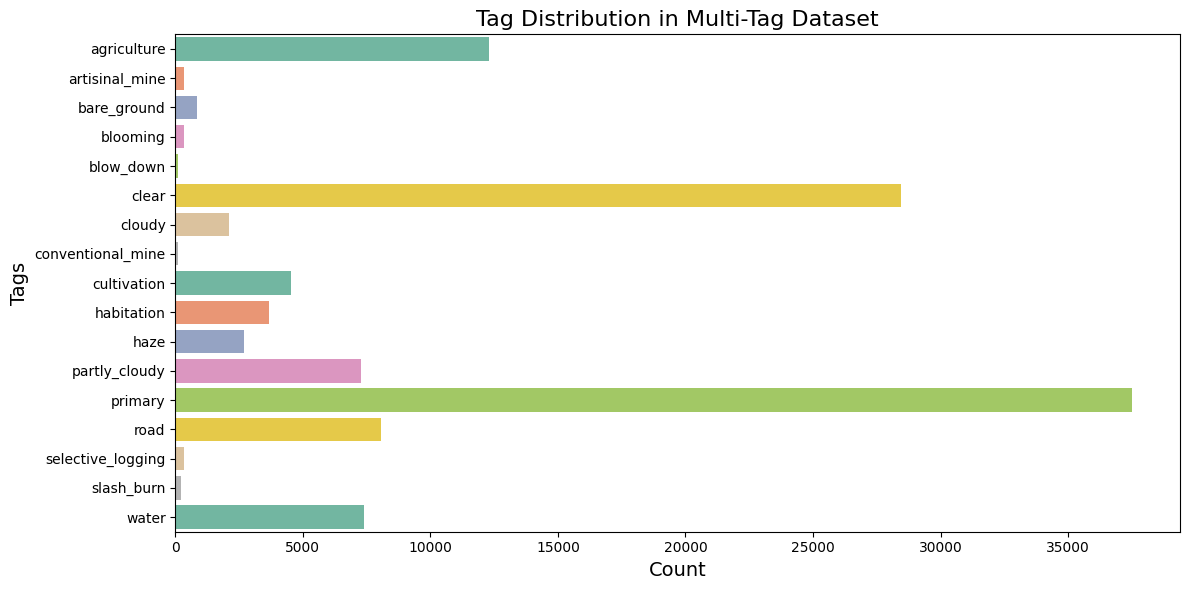

Standard Deviation of Tag Frequencies: 37670.58183190001
IRperLabel: {'agriculture': 0.3042318239086934, 'artisinal_mine': 0.00837471281405173, 'bare_ground': 0.021294992465228885, 'blooming': 0.00820178364090022, 'blow_down': 0.0024210084241211493, 'clear': 0.702364188838657, 'cloudy': 0.05160700610192939, 'conventional_mine': 0.002470416759307295, 'cultivation': 0.11060055831418761, 'habitation': 0.090417253390647, 'haze': 0.06662713999851776, 'partly_cloudy': 0.1793769608933027, 'primary': 0.9267274389189456, 'road': 0.1993873366436918, 'selective_logging': 0.008399416981644803, 'slash_burn': 0.005163171026952247, 'water': 0.18308258603226366}
MeanIR: 0.16886751736194366
CVIR: 1.5019480501275149


In [8]:
plot_spread(df)
get_std_dev(df)
IR = calculate_IRperLabel(all_tags, df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

# Generation

In [11]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        # if type(csv_file) != str:
        #     self.df = csv_file
        # else:
        #     self.df = pd.read_csv(csv_file)
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        if "aug" in img_name:
            img_path = os.path.join("data/augmented_images/", f"{img_name}.jpg")
            #img_path = os.path.join(self.img_dir, f"{img_name}")
        else:
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        #print(image.shape)
        # Data Augmentation
        image_np = image.permute(1, 2, 0).cpu().numpy()
        # Ensure the image is in the range [0, 255] and has dtype uint8 if needed
        #image_np = (image_np * 255).astype(np.uint8)
        augmented = augmentation_pipeline(image=image_np)
        augmented_image = augmented['image']
        image = augmented_image
        
        tags = self.df.iloc[idx, 1].split()
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1
        
        return image, labels

In [14]:
# ResNet & DenseNet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# EfficientNet_b1
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(240),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# RegNet
# transform = transforms.Compose([
#     transforms.Resize(232),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# ConvNext
# transform = transforms.Compose([
#     transforms.Resize(236),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [18]:
# Create validation group before anything happens
df_to_load = df

dataset = MultiLabelImageDataset(df_to_load, img_dir="data/planet\planet/train-jpg", transform=transform)
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
print(val_idx)

train = df_to_load.iloc[train_idx]
print(train.shape)

[34602, 11243, 14499, 18918, 30631, 21503, 39602, 27556, 19889, 31739, 740, 31191, 11178, 25166, 6013, 16680, 5936, 10331, 11626, 16443, 26446, 25802, 31269, 14731, 39717, 216, 2020, 8966, 24516, 15045, 12536, 39223, 1557, 24008, 31070, 34818, 10575, 37184, 33810, 28501, 11893, 18963, 3161, 32268, 23628, 35696, 4032, 36898, 34614, 34807, 17394, 5770, 36774, 23425, 9296, 13208, 23779, 7781, 14791, 24906, 9317, 5697, 27842, 36926, 40141, 34102, 5501, 4563, 11684, 4810, 13352, 22894, 12983, 23947, 34863, 16769, 25080, 2528, 4448, 24615, 28122, 24040, 5536, 27135, 37442, 17298, 24607, 40106, 14125, 39430, 7094, 19211, 31564, 17191, 35403, 5954, 40260, 36169, 16372, 21420, 36189, 30074, 3861, 12200, 12512, 29044, 24492, 20275, 12859, 4850, 19697, 8450, 24559, 36625, 37332, 5401, 27902, 4215, 8613, 34079, 1139, 11028, 20603, 14926, 29500, 36260, 23038, 25853, 38968, 9312, 2276, 1992, 18245, 11224, 37967, 38771, 7625, 21027, 6424, 31006, 22697, 21299, 9836, 30705, 20755, 32065, 39103, 36913, 

## Undersampling

#### Setup (For LP-RUS, LP-ROS, ML-RUS & ML-ROS)

In [19]:
from skmultilearn.problem_transform import LabelPowerset

X = train["image_name"].values
y = train["tags"].values
y_binary = np.zeros((len(y), len(tag_to_idx)), dtype=int)

# Populate the binary matrix
for i, tags in enumerate(y):
    for tag in tags.split():  # Split tags by space
        tag_id = tag_to_idx[tag]
        y_binary[i, tag_id] = 1

print(y.shape) # (36431, )
print(y_binary.shape) # (36431, 17)
#print(y[0])
X = X.reshape(-1, 1)
print(X.shape)

lp = LabelPowerset()
X_transformed = X
y_transformed = lp.transform(y_binary)
print(X_transformed.shape)
y_transformed = y.reshape(-1,1)

print(y_transformed.shape)
#print(y_transformed)

(36431,)
(36431, 17)
(36431, 1)
(36431, 1)
(36431, 1)


### Label Powerset based Random Undersampling (LP-RUS)

In [20]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random undersampling
ros = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = ros.fit_resample(X_transformed, y_transformed)

LP_undersampled_df = pd.DataFrame(X_undersampled)

# Add the decoded labels as a column to the DataFrame
LP_undersampled_df['tags'] = y_undersampled
print(LP_undersampled_df)

               0                                               tags
0    train_20674  agriculture artisinal_mine bare_ground clear p...
1     train_2330  agriculture artisinal_mine bare_ground clear p...
2     train_9528  agriculture artisinal_mine clear conventional_...
3      train_185  agriculture artisinal_mine clear cultivation h...
4     train_1340  agriculture artisinal_mine clear cultivation h...
..           ...                                                ...
428  train_10064                   partly_cloudy primary slash_burn
429   train_7888                        partly_cloudy primary water
430    train_340                           partly_cloudy road water
431  train_23783                                partly_cloudy water
432  train_24448                                              water

[433 rows x 2 columns]


C:\Users\xxpur\AppData\Local\Temp\ipykernel_20192\3117131438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


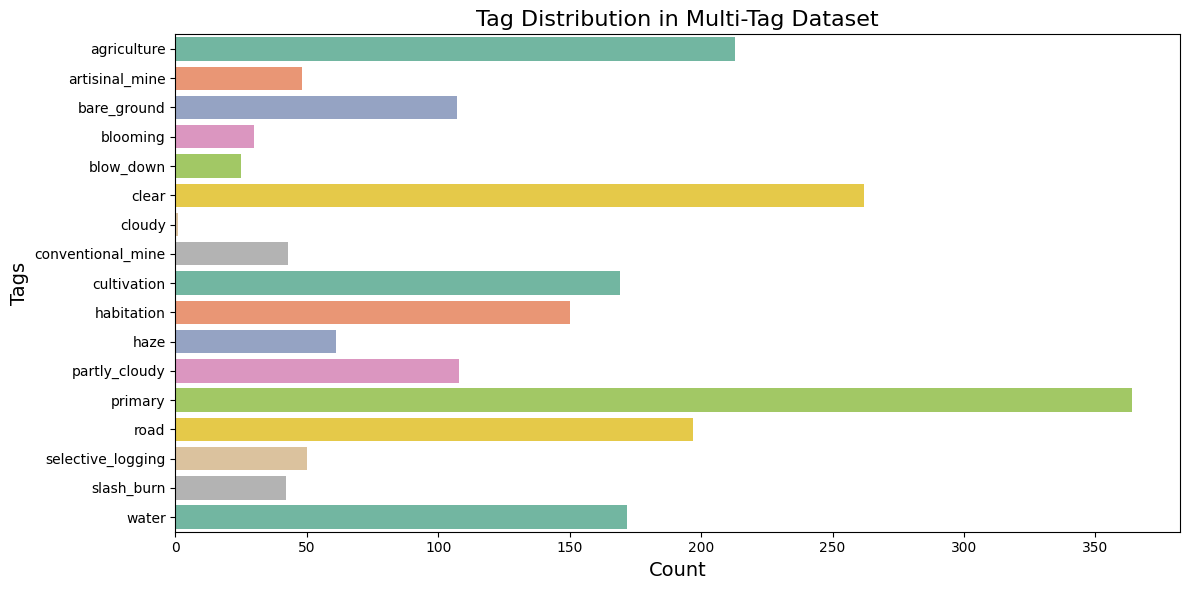

Standard Deviation of Tag Frequencies: 594.1640057967994
IRperLabel: {'agriculture': 0.49191685912240185, 'artisinal_mine': 0.11085450346420324, 'bare_ground': 0.2471131639722864, 'blooming': 0.06928406466512702, 'blow_down': 0.053117782909930716, 'clear': 0.605080831408776, 'cloudy': 0.0023094688221709007, 'conventional_mine': 0.09930715935334873, 'cultivation': 0.3510392609699769, 'habitation': 0.3464203233256351, 'haze': 0.14087759815242495, 'partly_cloudy': 0.24942263279445728, 'primary': 0.8406466512702079, 'road': 0.45496535796766746, 'selective_logging': 0.11547344110854503, 'slash_burn': 0.09699769053117784, 'water': 0.3972286374133949}
MeanIR: 0.27482678983833725
CVIR: 0.806150934313288


In [21]:
plot_spread(LP_undersampled_df)
get_std_dev(LP_undersampled_df)
IR = calculate_IRperLabel(all_tags, LP_undersampled_df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

### Multi Label Random Undersampling (ML-RUS)

In [24]:
# Function to calculate Imbalance Ratio (IR)
def calculate_imbalance_ratio(y_binary):
    label_counts = np.sum(y_binary, axis=0)  # Sum across rows to count label occurrences
    total_samples = len(y_binary)
    imbalance_ratios = label_counts / total_samples  # IR = count of label / total samples
    return imbalance_ratios

# Function to delete majority samples
def ml_rus(X, y_binary, target_size):
    #print(y_binary)
    current_size = len(X)
    samples_to_remove = current_size - target_size
    
    # Calculate imbalance ratios
    imbalance_ratios = calculate_imbalance_ratio(y_binary)
    mean_ir = np.mean(imbalance_ratios)
    
    # Identify minority label sets based on imbalance ratio
    majority_indices = []
    for i in range(len(y_binary)): # NOTE: This is not random!
        # Check if the sample belongs to a minority class (based on IR)
        label_ir = np.sum(y_binary[i]) / len(y_binary[i])  # Sum of labels divided by number of labels
        if label_ir > mean_ir:
            majority_indices.append(i)
    
    # Randomly remove samples from majority_indices until target size is reached
    if samples_to_remove > len(majority_indices):
        print("Not enough majority indices to remove, removal is limited.")
        samples_to_remove = len(majority_indices)
    random_indices_to_remove = np.random.choice(majority_indices, samples_to_remove, replace=False)
    
    # Remove selected samples
    X_resampled = np.delete(X, random_indices_to_remove, axis=0)
    y_resampled = np.delete(y_binary, random_indices_to_remove, axis=0)
    

    X_resampled = np.reshape(X_resampled,-1)
    return X_resampled, y_resampled

# Define the target size (desired number of samples after oversampling)
target_size = len(X) / 2  # Half the size of the dataset as an example

# Apply ML-ROS to clone minority samples
X_resampled, y_resampled = ml_rus(X, y_binary, target_size)

print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)

# Convert resampled binary labels (y_resampled) back to tag strings
ML_undersampled_df = pd.DataFrame({
    'image_name': X_resampled,
    'tags': [' '.join([k for k, v in tag_to_idx.items() if row[v] == 1]) for row in y_resampled]
})

print(ML_undersampled_df)

Not enough majority indices to remove, removal is limited.
Resampled X shape: (19105,)
Resampled y shape: (19105, 17)
        image_name                   tags
0      train_20036          clear primary
1      train_14128          clear primary
2      train_35719           haze primary
3      train_12384  partly_cloudy primary
4       train_1282          clear primary
...            ...                    ...
19100  train_16023                 cloudy
19101  train_37194          clear primary
19102  train_16850          clear primary
19103   train_6265          clear primary
19104    train_860                 cloudy

[19105 rows x 2 columns]


C:\Users\xxpur\AppData\Local\Temp\ipykernel_20192\3117131438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


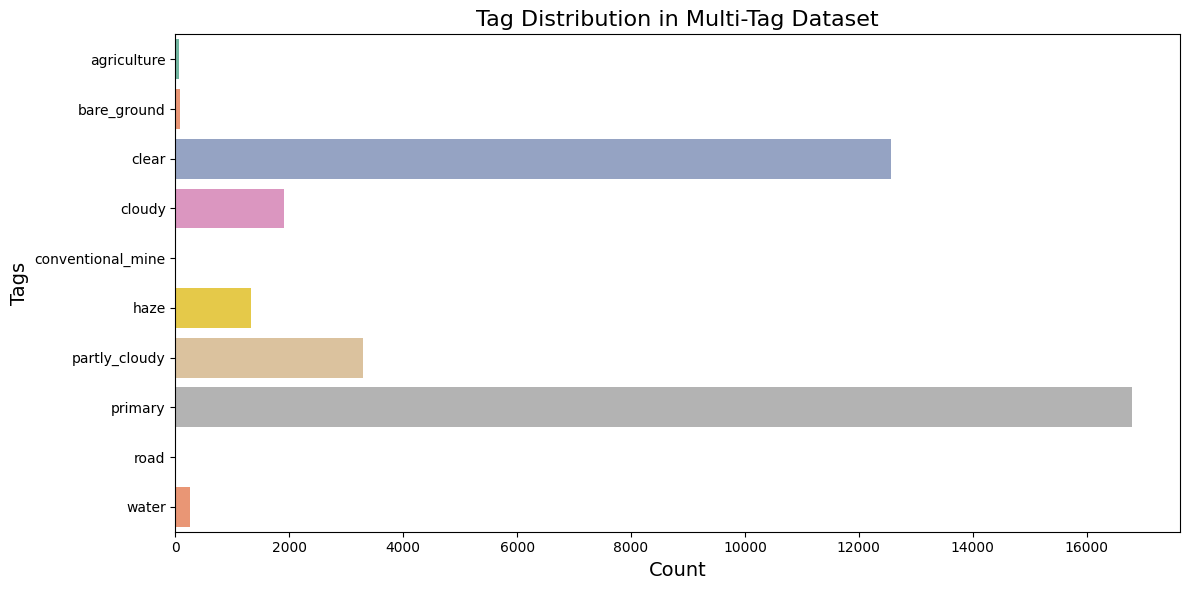

Standard Deviation of Tag Frequencies: 12780.947954340876
IRperLabel: {'agriculture': 0.0028788275320596702, 'artisinal_mine': 0.0, 'bare_ground': 0.003978016226118817, 'blooming': 0.0, 'blow_down': 0.0, 'clear': 0.6579429468725465, 'cloudy': 0.1001308557969118, 'conventional_mine': 0.00010468463752944256, 'cultivation': 0.0, 'habitation': 0.0, 'haze': 0.0698769955509029, 'partly_cloudy': 0.17199685946087412, 'primary': 0.8793509552473174, 'road': 5.234231876472128e-05, 'selective_logging': 0.0, 'slash_burn': 0.0, 'water': 0.013451975922533369}
MeanIR: 0.11175085056267994
CVIR: 2.2117553813714945


In [25]:
plot_spread(ML_undersampled_df)
get_std_dev(ML_undersampled_df)
IR = calculate_IRperLabel(all_tags, ML_undersampled_df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

## Oversampling

### Label Powerset based Random Oversampling (LP-ROS)

In [26]:
from imblearn.over_sampling import RandomOverSampler

# Apply random oversampling
ros = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = ros.fit_resample(X_transformed, y_transformed)

LP_oversampled_df = pd.DataFrame(X_oversampled)

# Add the decoded labels as a column to the DataFrame
LP_oversampled_df['tags'] = y_oversampled
print(LP_oversampled_df)

                   0                                       tags
0        train_20036                              clear primary
1        train_14128                              clear primary
2        train_36209      agriculture clear cultivation primary
3        train_40120      agriculture clear cultivation primary
4        train_36162  agriculture clear primary road slash_burn
...              ...                                        ...
5298183  train_24448                                      water
5298184  train_24448                                      water
5298185  train_24448                                      water
5298186  train_24448                                      water
5298187  train_24448                                      water

[5298188 rows x 2 columns]


C:\Users\xxpur\AppData\Local\Temp\ipykernel_6728\3117131438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


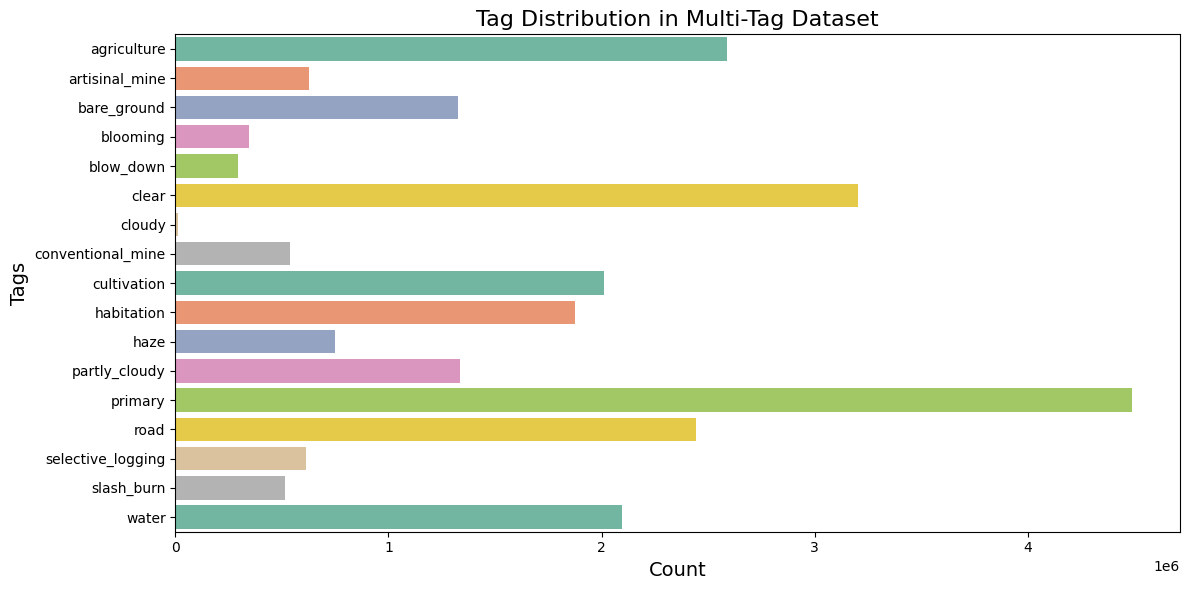

Standard Deviation of Tag Frequencies: 7305453.17364137
IRperLabel: {'agriculture': 0.48729792147806006, 'cultivation': 0.3371824480369515, 'cloudy': 0.0023094688221709007, 'selective_logging': 0.11547344110854503, 'water': 0.394919168591224, 'road': 0.45958429561200925, 'blow_down': 0.050808314087759814, 'artisinal_mine': 0.11778290993071594, 'blooming': 0.06466512702078522, 'conventional_mine': 0.10161662817551963, 'bare_ground': 0.24942263279445728, 'clear': 0.6027713625866051, 'primary': 0.8452655889145496, 'habitation': 0.3533487297921478, 'haze': 0.14087759815242495, 'partly_cloudy': 0.2517321016166282, 'slash_burn': 0.09699769053117784}
MeanIR: 0.2748267898383372
CVIR: 0.8069595137636987


In [70]:
plot_spread(LP_oversampled_df)
get_std_dev(LP_oversampled_df)
IR = calculate_IRperLabel(all_tags, LP_oversampled_df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

### Multi Label Random Oversampling (ML-ROS)

In [32]:
# Function to calculate Imbalance Ratio (IR)
def calculate_imbalance_ratio(y_binary):
    label_counts = np.sum(y_binary, axis=0)  # Sum across rows to count label occurrences
    total_samples = len(y_binary)
    imbalance_ratios = label_counts / total_samples  # IR = count of label / total samples
    return imbalance_ratios

# Function to clone minority samples
def ml_ros_clone(X, y_binary, target_size):
    #print(y_binary)
    current_size = len(X)
    samples_to_add = target_size - current_size
    
    # Calculate imbalance ratios
    imbalance_ratios = calculate_imbalance_ratio(y_binary)
    mean_ir = np.mean(imbalance_ratios)
    
    # Identify minority label sets based on imbalance ratio
    minority_indices = []
    for i in range(len(y_binary)):
        # Check if the sample belongs to a minority class (based on IR)
        label_ir = np.sum(y_binary[i]) / len(y_binary[i])  # Sum of labels divided by number of labels
        if label_ir < mean_ir:
            minority_indices.append(i)
    
    # # Clone the minority samples, NOTE this is not random!
    # while samples_to_add > 0:
    #     for i in minority_indices:
    #         if samples_to_add <= 0:
    #             break
    #         X = np.append(X, X[i])  # Clone the image name (image name is being duplicated)
    #         y_binary = np.vstack([y_binary, y_binary[i]])  # Clone the corresponding label vector
    #         samples_to_add -= 1

    # Clone the minority samples randomly
    while samples_to_add > 0:
        # Randomly pick indices from minority samples
        random_indices = np.random.choice(minority_indices, min(samples_to_add, len(minority_indices)), replace=True)
        
        # Append the randomly selected samples
        X = np.append(X, X[random_indices])
        y_binary = np.vstack([y_binary, y_binary[random_indices]])

        samples_to_add -= len(random_indices)
    
    print(X.shape)
    return X, y_binary

# Define the target size (desired number of samples after oversampling)
target_size = len(X) * 2  # Double the size of the dataset as an example

# Apply ML-ROS to clone minority samples
X_resampled, y_resampled = ml_ros_clone(X, y_binary, target_size)

print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)

# Convert resampled binary labels (y_resampled) back to tag strings
ML_oversampled_df = pd.DataFrame({
    'image_name': X_resampled,
    'tags': [' '.join([k for k, v in tag_to_idx.items() if row[v] == 1]) for row in y_resampled]
})

print(ML_oversampled_df)


(72862,)
Resampled X shape: (72862,)
Resampled y shape: (72862, 17)
        image_name                                       tags
0      train_20036                              clear primary
1      train_14128                              clear primary
2      train_36209      agriculture clear cultivation primary
3      train_40120      agriculture clear cultivation primary
4      train_36162  agriculture clear primary road slash_burn
...            ...                                        ...
72857  train_17847                              clear primary
72858  train_11202                              clear primary
72859  train_32299                                clear water
72860  train_36859                              clear primary
72861  train_10332                      partly_cloudy primary

[72862 rows x 2 columns]


C:\Users\xxpur\AppData\Local\Temp\ipykernel_20192\3117131438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


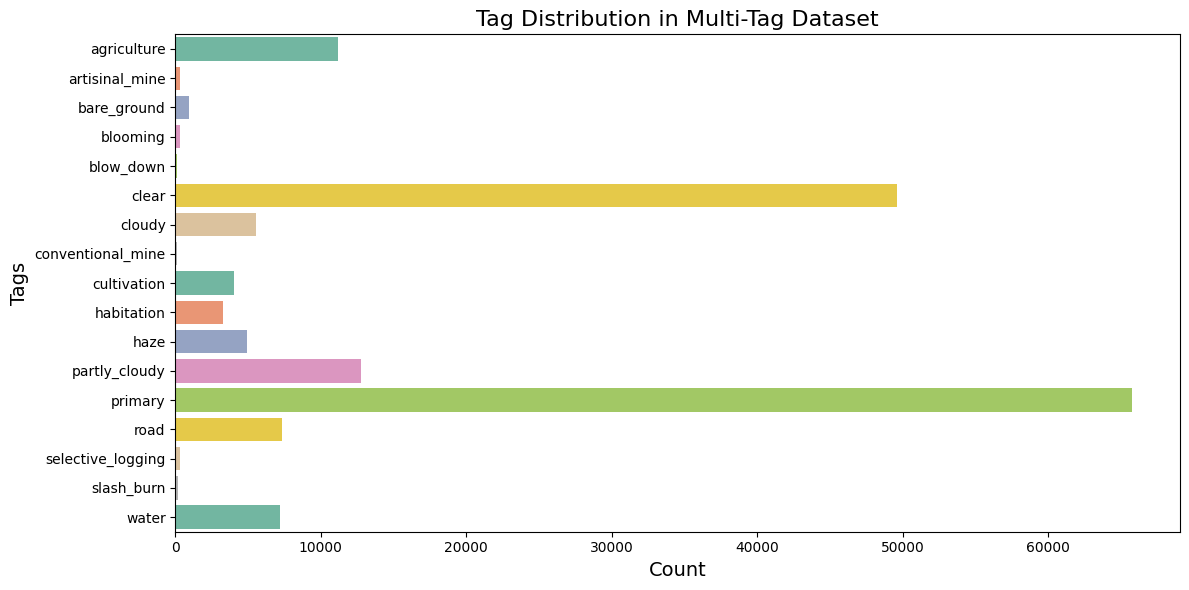

Standard Deviation of Tag Frequencies: 57423.78272307427
IRperLabel: {'agriculture': 0.1532897806812879, 'artisinal_mine': 0.004144821717767835, 'bare_ground': 0.012736405808240234, 'blooming': 0.004172270868216628, 'blow_down': 0.0011116905931761413, 'clear': 0.6811094946611402, 'cloudy': 0.07614394334495347, 'conventional_mine': 0.0012352117701957125, 'cultivation': 0.05548845763223628, 'habitation': 0.045208750789163074, 'haze': 0.067826850758969, 'partly_cloudy': 0.17487853750926408, 'primary': 0.9028849057121682, 'road': 0.10017567456287228, 'selective_logging': 0.004378139496582581, 'slash_burn': 0.002511597266064615, 'water': 0.09873459416431062}
MeanIR: 0.14035477219627107
CVIR: 1.757005209021338


In [33]:
plot_spread(ML_oversampled_df)
get_std_dev(ML_oversampled_df)
IR = calculate_IRperLabel(all_tags, ML_oversampled_df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

### SMOTE

In [ ]:
# Taken from https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote 

def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

## REMEDIAL

In [34]:
# Calculate SCUMBLE_ins(i) for an instance
def calculate_SCUMBLE_ins(IR, instance_labels):
    if not instance_labels:  # Handle case where instance has no labels
        return 0
    
    IRL_bl_i = max(IR[label] for label in instance_labels)  # Max IR for instance's labels
    product_IR = np.prod([IR[label] for label in instance_labels])  # Product of IRs
    L = len(instance_labels)  # Number of labels for the instance
    
    # Calculate SCUMBLE_ins(i)
    SCUMBLE_ins = 1 - (1 / IRL_bl_i) * (product_IR ** (1 / L))
    return SCUMBLE_ins

# Calculate SCUMBLE(D) for the entire dataset
def calculate_SCUMBLE(IR, df):
    df['label_list'] = df['tags'].apply(lambda x: x.split())  # Ensure label_list exists
    SCUMBLE_values = [
        calculate_SCUMBLE_ins(IR, instance_labels) for instance_labels in df['label_list']
    ]
    SCUMBLE_D = np.mean(SCUMBLE_values) if SCUMBLE_values else 0  # Average SCUMBLE values
    return SCUMBLE_D

def REMEDIAL(df, all_labels):
    """
    Implements the REMEDIAL function to balance a multi-label dataset.
    
    :param df: DataFrame with a 'tags' column containing space-separated labels for each instance.
    :param all_labels: List of all possible labels in the dataset.
    :return: Modified DataFrame with balanced instances.
    """
    # Step 1: Calculate imbalance levels (IR per label)
    IR = calculate_IRperLabel(all_labels, df)
    IRMean = np.mean(list(IR.values()))  # Mean of IRs

    # Step 2: Calculate SCUMBLE for each instance
    df['label_list'] = df['tags'].apply(lambda x: x.split())
    df['SCUMBLE_ins'] = df['label_list'].apply(lambda labels: calculate_SCUMBLE_ins(IR, labels))
    SCUMBLE = np.mean(df['SCUMBLE_ins'])  # Dataset-level SCUMBLE

    # Step 3: Process each instance
    balanced_instances = []
    for _, row in df.iterrows():
        if row['SCUMBLE_ins'] > SCUMBLE:
            # Clone the affected instance
            cloned_instance = row.copy()

            # Retain minority labels in cloned datapoint
            minority_labels = [label for label in row['label_list'] if IR[label] <= IRMean]

            # Retain majority labels in original datapoint
            majority_labels = [label for label in row['label_list'] if IR[label] > IRMean]

            # Update the cloned instance
            cloned_instance['label_list'] = minority_labels

            if len(majority_labels) > 0:
                # ENSURE THAT AT LEAST 1 TAG REMAINS
                row['label_list'] = majority_labels

            # Add the updated instances back to the dataset
            # ENSURE THAT AT LEAST 1 TAG IS GIVEN
            if len(minority_labels) > 0:
                balanced_instances.append(cloned_instance)

        balanced_instances.append(row)

    # Recreate the DataFrame with updated labels
    balanced_df = pd.DataFrame(balanced_instances)
    balanced_df['tags'] = balanced_df['label_list'].apply(lambda x: ' '.join(x))
    return balanced_df

# Calculate SCUMBLE(D)
SCUMBLE_original = calculate_SCUMBLE(IR, df)

print("IR per Label:", IR)
print("SCUMBLE(D):", SCUMBLE_original)


REMEDIAL_modified_df = REMEDIAL(df, all_tags)


IR per Label: {'agriculture': 0.1532897806812879, 'artisinal_mine': 0.004144821717767835, 'bare_ground': 0.012736405808240234, 'blooming': 0.004172270868216628, 'blow_down': 0.0011116905931761413, 'clear': 0.6811094946611402, 'cloudy': 0.07614394334495347, 'conventional_mine': 0.0012352117701957125, 'cultivation': 0.05548845763223628, 'habitation': 0.045208750789163074, 'haze': 0.067826850758969, 'partly_cloudy': 0.17487853750926408, 'primary': 0.9028849057121682, 'road': 0.10017567456287228, 'selective_logging': 0.004378139496582581, 'slash_burn': 0.002511597266064615, 'water': 0.09873459416431062}
SCUMBLE(D): 0.46292469254395746


C:\Users\xxpur\AppData\Local\Temp\ipykernel_20192\3117131438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


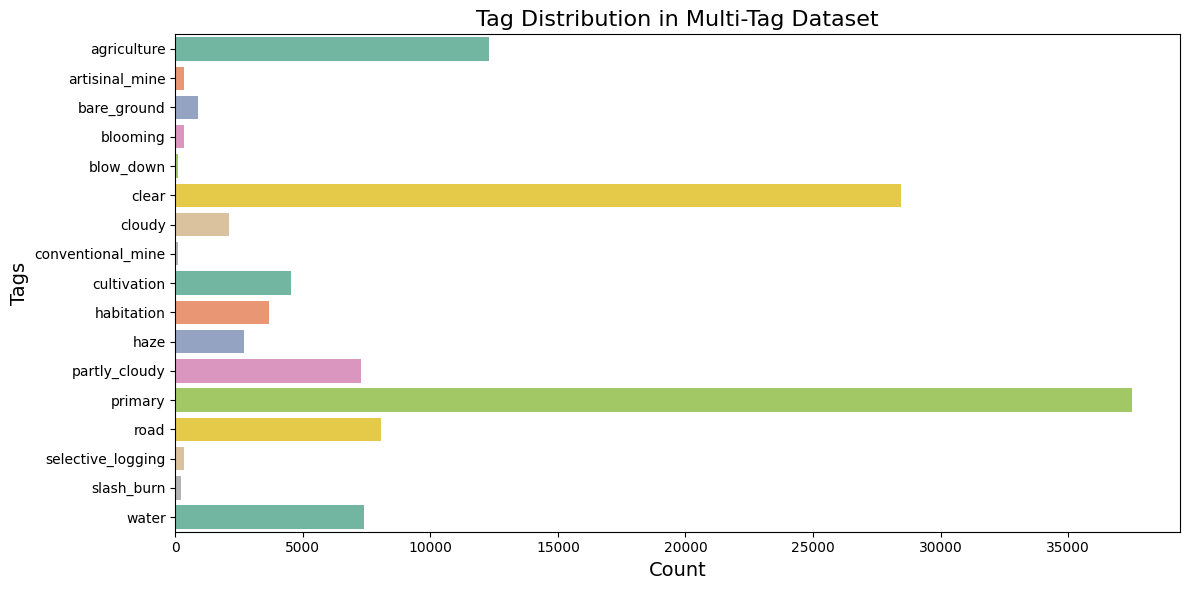

Standard Deviation of Tag Frequencies: 37274.402261838026
IRperLabel: {'agriculture': 0.2381597014059448, 'artisinal_mine': 0.006555918698872537, 'bare_ground': 0.01680558510123963, 'blooming': 0.006420545746388443, 'blow_down': 0.0018952213347773114, 'clear': 0.5498269160107525, 'cloudy': 0.040399156819895955, 'conventional_mine': 0.0019338993212013383, 'cultivation': 0.08658067261018391, 'habitation': 0.07078071515596898, 'haze': 0.05229263764528418, 'partly_cloudy': 0.14042042971242918, 'primary': 0.7254636523622581, 'road': 0.15608501421416002, 'selective_logging': 0.00657525769208455, 'slash_burn': 0.004041849581310797, 'water': 0.14332127869423117}
MeanIR: 0.13220932071217548
CVIR: 1.5017078325903277
SCUMBLE: 0.2674823061094963


In [35]:
plot_spread(REMEDIAL_modified_df)
get_std_dev(REMEDIAL_modified_df)
IR = calculate_IRperLabel(all_tags, REMEDIAL_modified_df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)
scumble = calculate_SCUMBLE(IR, REMEDIAL_modified_df)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)
print("SCUMBLE:", scumble)

# Export Dataframes and Images

In [36]:
# some of the dataframes have additional columns
LP_undersampled_df.rename(columns={0: 'image_name'}, inplace=True)
LP_oversampled_df.rename(columns={0: 'image_name'}, inplace=True)
ML_undersampled_df.rename(columns={0: 'image_name'}, inplace=True)
ML_oversampled_df.rename(columns={0: 'image_name'}, inplace=True)
REMEDIAL_modified_df.rename(columns={0: 'image_name'}, inplace=True)

LP_undersampled_df = LP_undersampled_df[["image_name", "tags"]]
LP_oversampled_df = LP_oversampled_df[["image_name", "tags"]]
ML_undersampled_df = ML_undersampled_df[["image_name", "tags"]]
ML_oversampled_duplicate_df = ML_oversampled_df[["image_name", "tags"]]
REMEDIAL_modified_df = REMEDIAL_modified_df[["image_name", "tags"]]

In [37]:

LP_undersampled_df.to_csv("LP_undersampled_df.csv", index=False)
LP_oversampled_df.to_csv("LP_oversampled_df.csv", index=False)
ML_undersampled_df.to_csv("ML_undersampled_df.csv", index=False, columns=["image_name", "tags"])
ML_oversampled_df.to_csv("ML_oversampled_df.csv", index=False, columns=["image_name", "tags"])
REMEDIAL_modified_df.to_csv("REMEDIAL_modified_df.csv", index=False, columns=["image_name", "tags"])

# Import Dataframes

In [130]:
LP_undersampled_df = pd.read_csv("LP_undersampled_df.csv")
LP_oversampled_df = pd.read_csv("LP_oversampled_df.csv")
ML_undersampled_df = pd.read_csv("ML_undersampled_df.csv")
ML_oversampled_duplicate_df = pd.read_csv("ML_oversampled_duplicate_df.csv")
ML_oversampled_augment_df = pd.read_csv("ML_oversampled_augment_df.csv")
REMEDIAL_modified_df = pd.read_csv("REMEDIAL_modified_df.csv")

In [131]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        # if type(csv_file) != str:
        #     self.df = csv_file
        # else:
        #     self.df = pd.read_csv(csv_file)
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        if "aug" in img_name:
            img_path = os.path.join("data/augmented_images/", f"{img_name}.jpg")
            #img_path = os.path.join(self.img_dir, f"{img_name}")
        else:
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        tags = self.df.iloc[idx, 1].split()
        
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1
        
        return image, labels

# Testing

In [16]:
# ResNet & DenseNet
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# EfficientNet_b1
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(240),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [132]:
df_to_load = REMEDIAL_modified_df

dataset = MultiLabelImageDataset(df_to_load, img_dir="data/planet\planet/train-jpg", transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
# Since valiation split already done above with original data so no need

# # Only quick testing
#train_idx_small = train_idx[:1000]  # First 1000 training samples
#test_idx_small = test_idx[:200]  # First 200 testing samples

#train_idx_small = train_idx[:32787] 
#test_idx_small = test_idx[:3644] 

#train_dataset = Subset(dataset, train_idx_small)
#test_dataset = Subset(dataset, test_idx_small)
train_dataset = Subset(dataset, list(range(len(df_to_load))))
val_dataset = MultiLabelImageDataset(val, img_dir="data/planet\planet/train-jpg", transform=transform)
val_dataset = Subset(val_dataset, list(range(len(val))))

#train_dataset = Subset(dataset, train_idx)
#test_dataset = Subset(dataset, test_idx)

print(len(train_idx))
print(len(test_idx))



batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

46538
5171


In [29]:
import torchvision.models as models
from torch import nn

num_classes = 17

def ResNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.resnet50(weights='DEFAULT')
    num_ftrs = model_ft.fc.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

def EfficientNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.efficientnet_b1(weights='DEFAULT')
    # num_ftrs = model_ft.classifier.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(1280, num_classes)
    return model_ft

In [133]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#model = ResNetClassifier(num_classes)
model = EfficientNetClassifier(num_classes)
model.to(device)
#model

Using cuda device


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [134]:
def train_loop(dataloader, val_dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 64 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        if batch % 640 == 0:
            val_loop(val_dataloader, model, loss_fn)


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    test_loss /= num_batches
    f2 /= num_batches
    
    print(f"Test Error: \n f2 score: {f2:.5f}, avg loss: {test_loss:>8f} \n")
    return f2, test_loss

def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.17 #0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    val_loss /= num_batches
    f2 /= num_batches
    
    print(f"Val Error: \n f2 score: {f2:.5f}, avg loss: {val_loss:>8f} \n")
    return f2, val_loss


In [135]:
learning_rate = 1e-4 #0.00001
epochs = 5

In [136]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
all_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, val_dataloader, model, loss_fn, optimizer)
    #f2, test_loss = test_loop(test_dataloader, model, loss_fn)
    val_loop(val_dataloader, model, loss_fn)
    #all_loss.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.697881  [    8/51709]
Val Error: 
 f2 score: 0.50000, avg loss: 0.692531 

loss: 0.187430  [  520/51709]
loss: 0.132364  [ 1032/51709]
loss: 0.218940  [ 1544/51709]
loss: 0.133675  [ 2056/51709]
loss: 0.193060  [ 2568/51709]
loss: 0.107744  [ 3080/51709]
loss: 0.174075  [ 3592/51709]
loss: 0.167645  [ 4104/51709]
loss: 0.115936  [ 4616/51709]
loss: 0.172938  [ 5128/51709]
Val Error: 
 f2 score: 0.88439, avg loss: 0.144537 

loss: 0.099655  [ 5640/51709]
loss: 0.189718  [ 6152/51709]
loss: 0.109469  [ 6664/51709]
loss: 0.193250  [ 7176/51709]
loss: 0.111142  [ 7688/51709]
loss: 0.165072  [ 8200/51709]
loss: 0.117885  [ 8712/51709]
loss: 0.135598  [ 9224/51709]
loss: 0.177802  [ 9736/51709]
loss: 0.082192  [10248/51709]
Val Error: 
 f2 score: 0.89775, avg loss: 0.132244 

loss: 0.193232  [10760/51709]
loss: 0.096707  [11272/51709]
loss: 0.150464  [11784/51709]
loss: 0.087736  [12296/51709]
loss: 0.131557  [12808/51709]
loss: 0.066333  [1332

KeyboardInterrupt: 

In [ ]:
# IF MANUALLY UNFREEZING LAYERS
for param in model_ft.parameters():
    param.requires_grad = True